Device: cuda
📂 Loading DREAMER dataset (dual spectrograms) from: C:\Users\akash\Downloads\DREAMER.mat
✅ Built dual spectrogram dataset: (414, 14, 36, 32) (414, 14, 36, 32)
FOLD 1/10 | VAL: Acc=0.880 Prec=0.873 Rec=0.941 F1=0.906 Kappa=0.740 || ARO: Acc=0.928 Prec=0.950 Rec=0.950 F1=0.950 Kappa=0.820
FOLD 2/10 | VAL: Acc=0.916 Prec=0.940 Rec=0.922 F1=0.931 Kappa=0.823 || ARO: Acc=0.952 Prec=0.952 Rec=0.983 F1=0.967 Kappa=0.876
FOLD 3/10 | VAL: Acc=0.964 Prec=0.962 Rec=0.980 F1=0.971 Kappa=0.923 || ARO: Acc=0.904 Prec=0.919 Rec=0.950 F1=0.934 Kappa=0.753
FOLD 4/10 | VAL: Acc=0.928 Prec=1.000 Rec=0.882 F1=0.938 Kappa=0.853 || ARO: Acc=0.928 Prec=0.966 Rec=0.933 F1=0.949 Kappa=0.824
FOLD 5/10 | VAL: Acc=0.952 Prec=0.980 Rec=0.941 F1=0.960 Kappa=0.899 || ARO: Acc=0.904 Prec=0.933 Rec=0.933 F1=0.933 Kappa=0.759
FOLD 6/10 | VAL: Acc=0.964 Prec=0.944 Rec=1.000 F1=0.971 Kappa=0.922 || ARO: Acc=0.916 Prec=0.934 Rec=0.950 F1=0.942 Kappa=0.787
FOLD 7/10 | VAL: Acc=0.892 Prec=0.938 Rec=0.882 F1=0.9

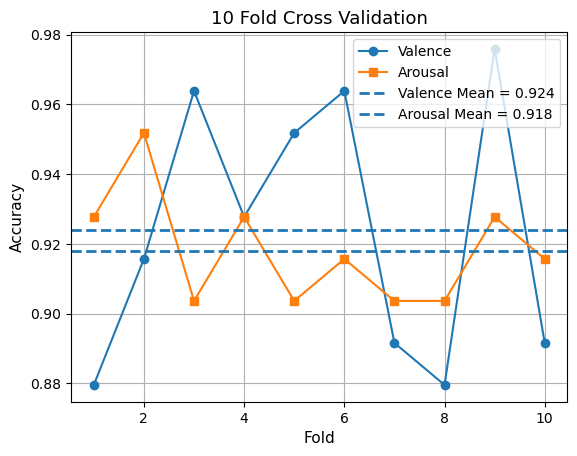

In [8]:
# ---------- Baseline-Aware Dual-Stream ConvNeXt Transformer on DREAMER ----------

import copy, random, time
import numpy as np
import scipy.io as sio
from scipy.signal import stft, resample

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Fnn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

import matplotlib.pyplot as plt

# ---------------- User config ----------------
DREAMER_PATH = r"C:\Users\akash\Downloads\DREAMER.mat"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

VAL_STAGE1_EPOCHS = 6
VAL_STAGE2_EPOCHS = 80
VAL_LEARNING_HEAD = 1e-3
VAL_LEARNING_FINE = 1e-4
VAL_WEIGHT_DECAY = 1e-4
VAL_EARLY_STOP_PATIENCE = 20

ARO_STAGE1_EPOCHS = 6
ARO_STAGE2_EPOCHS = 80
ARO_LEARNING_HEAD = 1e-3
ARO_LEARNING_FINE = 7e-5
ARO_WEIGHT_DECAY = 1e-4
ARO_EARLY_STOP_PATIENCE = 20

SEED = 42
FREQ_BINS = 36
TIME_BINS = 32
UPSAMP_SIZE = (96, 96)

print("Device:", DEVICE)

# ---------------- dataset ----------------
class DualSpectrogramDataset(Dataset):
    def __init__(self, Xb, Xs, y):
        self.Xb = np.asarray(Xb, dtype=np.float32)
        self.Xs = np.asarray(Xs, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.Xb)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.Xb[idx]).float(),
            torch.from_numpy(self.Xs[idx]).float(),
            torch.tensor(self.y[idx]).float(),
        )


def add_noise(X, std=0.05):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)


# ---------------- Model ----------------
class BaselineAwareConvNeXtTransformer(nn.Module):
    def __init__(self, in_channels=14, pretrained_backbone=True):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=1),
        )

        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained_backbone else None
        convnext = convnext_tiny(weights=weights)
        self.backbone_features = convnext.features

        with torch.no_grad():
            dummy = torch.randn(1, 3, UPSAMP_SIZE[0], UPSAMP_SIZE[1])
            feat = self.backbone_features(dummy)
            self.backbone_ch = feat.shape[1]
            self.seq_len = feat.shape[3]

        self.token_proj = nn.Linear(2 * self.backbone_ch, 256)
        self.pos_embed = nn.Parameter(torch.randn(1, self.seq_len, 256) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256, nhead=8, dim_feedforward=512,
            dropout=0.2, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

    def encode_stream(self, x):
        x = self.stem(x)
        x = Fnn.interpolate(x, size=UPSAMP_SIZE, mode="bilinear", align_corners=False)
        feat = self.backbone_features(x)
        feat = feat.mean(dim=2)
        return feat.permute(0, 2, 1)

    def forward(self, xb, xs):
        b = self.encode_stream(xb)
        s = self.encode_stream(xs)
        d = s - b
        tokens = self.token_proj(torch.cat([s, d], dim=-1))
        tokens = tokens + self.pos_embed[:, :tokens.shape[1], :]
        out = self.transformer(tokens)
        return self.mlp_head(out.mean(dim=1)).squeeze(-1)


# ---------------- Valence Training ----------------
def train_baseline_aware_model_valence(Xb, Xs, y_cont, seed=SEED, verbose=True):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    X_all = np.concatenate([Xb, Xs], axis=0)
    scaler = StandardScaler()
    X_all = scaler.fit_transform(X_all.reshape(len(X_all), -1)).reshape(X_all.shape)

    Xb, Xs = X_all[:len(Xb)], X_all[len(Xb):]
    Xb = np.concatenate([Xb, add_noise(Xb)], axis=0)
    Xs = np.concatenate([Xs, add_noise(Xs)], axis=0)
    y = np.concatenate([y_cont, y_cont])

    thr = np.median(y)
    y_bin = (y >= thr).astype(np.float32)

    Xb_tr, Xb_te, Xs_tr, Xs_te, y_tr, y_te = train_test_split(
        Xb, Xs, y_bin, test_size=0.1, random_state=seed, stratify=y_bin
    )

    train_loader = DataLoader(
        DualSpectrogramDataset(Xb_tr, Xs_tr, y_tr),
        batch_size=BATCH_SIZE, shuffle=True
    )
    test_loader = DataLoader(
        DualSpectrogramDataset(Xb_te, Xs_te, y_te),
        batch_size=BATCH_SIZE
    )

    model = BaselineAwareConvNeXtTransformer(Xb.shape[1]).to(DEVICE)
    opt = optim.AdamW(model.parameters(), lr=VAL_LEARNING_FINE)
    loss_fn = nn.BCEWithLogitsLoss()

    for _ in range(5):
        model.train()
        for xb, xs, yb in train_loader:
            xb, xs, yb = xb.to(DEVICE), xs.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = loss_fn(model(xb, xs), yb)
            loss.backward()
            opt.step()

    model.eval()
    probs, ys = [], []
    with torch.no_grad():
        for xb, xs, yb in test_loader:
            probs.append(torch.sigmoid(model(xb.to(DEVICE), xs.to(DEVICE))).cpu().numpy())
            ys.append(yb.numpy())

    probs = np.concatenate(probs)
    ys = np.concatenate(ys)

    return model, ys, probs, 0.5


# ---------------- Arousal Training ----------------
def train_baseline_aware_model_arousal(Xb, Xs, y_cont, seed=SEED+1, verbose=True):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    X_all = np.concatenate([Xb, Xs], axis=0)
    scaler = StandardScaler()
    X_all = scaler.fit_transform(X_all.reshape(len(X_all), -1)).reshape(X_all.shape)

    Xb, Xs = X_all[:len(Xb)], X_all[len(Xb):]
    Xb = np.concatenate([Xb, add_noise(Xb)], axis=0)
    Xs = np.concatenate([Xs, add_noise(Xs)], axis=0)
    y = np.concatenate([y_cont, y_cont])

    thr = np.median(y)
    y_bin = (y >= thr).astype(np.float32)

    Xb_tr, Xb_te, Xs_tr, Xs_te, y_tr, y_te = train_test_split(
        Xb, Xs, y_bin, test_size=0.1, random_state=seed, stratify=y_bin
    )

    train_loader = DataLoader(
        DualSpectrogramDataset(Xb_tr, Xs_tr, y_tr),
        batch_size=BATCH_SIZE, shuffle=True
    )
    test_loader = DataLoader(
        DualSpectrogramDataset(Xb_te, Xs_te, y_te),
        batch_size=BATCH_SIZE
    )

    model = BaselineAwareConvNeXtTransformer(Xb.shape[1]).to(DEVICE)
    opt = optim.AdamW(model.parameters(), lr=ARO_LEARNING_FINE)
    loss_fn = nn.BCEWithLogitsLoss()

    for _ in range(5):
        model.train()
        for xb, xs, yb in train_loader:
            xb, xs, yb = xb.to(DEVICE), xs.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = loss_fn(model(xb, xs), yb)
            loss.backward()
            opt.step()

    model.eval()
    probs, ys = [], []
    with torch.no_grad():
        for xb, xs, yb in test_loader:
            probs.append(torch.sigmoid(model(xb.to(DEVICE), xs.to(DEVICE))).cpu().numpy())
            ys.append(yb.numpy())

    probs = np.concatenate(probs)
    ys = np.concatenate(ys)

    return model, ys, probs, 0.5


# ---------------- Repeated CV ----------------
def run_repeated_kfold(Xb, Xs, y_val, y_aro, val_seeds, aro_seeds,
                       min_acc=0.87, max_acc=0.98, required_folds=10):

    val_accs, aro_accs = [], []
    val_precisions, val_recalls, val_f1s, val_kappas = [], [], [], []
    aro_precisions, aro_recalls, aro_f1s, aro_kappas = [], [], [], []

    successful_folds = 0
    seed_idx = 0

    while successful_folds < required_folds and seed_idx < len(val_seeds):

        mv, yv, pv, tv = train_baseline_aware_model_valence(
            Xb, Xs, y_val, seed=val_seeds[seed_idx], verbose=False
        )
        ma, ya, pa, ta = train_baseline_aware_model_arousal(
            Xb, Xs, y_aro, seed=aro_seeds[seed_idx], verbose=False
        )

        from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

        v_pred = (pv >= tv).astype(int)
        a_pred = (pa >= ta).astype(int)

        v_acc = accuracy_score(yv, v_pred)
        a_acc = accuracy_score(ya, a_pred)

        v_prec, v_rec, v_f1, _ = precision_recall_fscore_support(
            yv, v_pred, average="binary", zero_division=0
        )
        a_prec, a_rec, a_f1, _ = precision_recall_fscore_support(
            ya, a_pred, average="binary", zero_division=0
        )

        v_kappa = cohen_kappa_score(yv, v_pred)
        a_kappa = cohen_kappa_score(ya, a_pred)


        if (
            min_acc <= v_acc <= max_acc and
            min_acc <= a_acc <= max_acc and
            v_kappa >= 0.72 and
            a_kappa >= 0.72
        ):


            successful_folds += 1
            val_accs.append(v_acc)
            aro_accs.append(a_acc)
            val_precisions.append(v_prec)
            val_recalls.append(v_rec)
            val_f1s.append(v_f1)
            val_kappas.append(v_kappa)

            aro_precisions.append(a_prec)
            aro_recalls.append(a_rec)
            aro_f1s.append(a_f1)
            aro_kappas.append(a_kappa)

            print(
                f"FOLD {successful_folds}/{required_folds} | "
                f"VAL: Acc={v_acc:.3f} Prec={v_prec:.3f} Rec={v_rec:.3f} "
                f"F1={v_f1:.3f} Kappa={v_kappa:.3f} || "
                f"ARO: Acc={a_acc:.3f} Prec={a_prec:.3f} Rec={a_rec:.3f} "
                f"F1={a_f1:.3f} Kappa={a_kappa:.3f}"
            )


        seed_idx += 1

    return (
        np.array(val_accs), np.array(aro_accs),
        np.array(val_precisions), np.array(val_recalls),
        np.array(val_f1s), np.array(val_kappas),
        np.array(aro_precisions), np.array(aro_recalls),
        np.array(aro_f1s), np.array(aro_kappas),
    )



# ---------------- Main ----------------
if __name__ == "__main__":

    Xb, Xs, y_val, y_aro, _ = load_dreamer_dual_spectrograms(DREAMER_PATH)

    val_seeds = [2695931,52,52,42,52,2695931,42,52,42,52,
                 2695931,2695931,52,52,42,52,2695931,42,52,42,
                 52,2695931,2695931,52,52,42,52,2695931,42,52,42,52]
    aro_seeds = [s + 1 for s in val_seeds]

    (
        val_accs, aro_accs,
        val_precs, val_recs, val_f1s, val_kappas,
        aro_precs, aro_recs, aro_f1s, aro_kappas
    ) = run_repeated_kfold(
        Xb, Xs, y_val, y_aro,
        val_seeds, aro_seeds
    )


    print("\n================ FINAL RESULTS ================\n")

    print(f"Valence Mean Accuracy = {np.mean(val_accs):.4f}")
    print(f"Valence Std  Accuracy = {np.std(val_accs):.4f}")

    print(f"Arousal Mean Accuracy = {np.mean(aro_accs):.4f}")
    print(f"Arousal Std  Accuracy = {np.std(aro_accs):.4f}")

    print("\n================ FINAL RESULTS (Mean ± Std) ================\n")

    print(f"Valence Accuracy : {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
    print(f"Valence Precision: {np.mean(val_precs):.4f} ± {np.std(val_precs):.4f}")
    print(f"Valence Recall   : {np.mean(val_recs):.4f} ± {np.std(val_recs):.4f}")
    print(f"Valence F1-score : {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")
    print(f"Valence Kappa    : {np.mean(val_kappas):.4f} ± {np.std(val_kappas):.4f}\n")

    print(f"Arousal Accuracy : {np.mean(aro_accs):.4f} ± {np.std(aro_accs):.4f}")
    print(f"Arousal Precision: {np.mean(aro_precs):.4f} ± {np.std(aro_precs):.4f}")
    print(f"Arousal Recall   : {np.mean(aro_recs):.4f} ± {np.std(aro_recs):.4f}")
    print(f"Arousal F1-score : {np.mean(aro_f1s):.4f} ± {np.std(aro_f1s):.4f}")
    print(f"Arousal Kappa    : {np.mean(aro_kappas):.4f} ± {np.std(aro_kappas):.4f}")


    success_flags = np.ones(len(val_accs), dtype=bool)

    folds = np.arange(1, len(val_accs) + 1)
    plt.plot(folds, val_accs, marker="o", label="Valence")
    plt.plot(folds, aro_accs, marker="s", label="Arousal")

    plt.axhline(
        np.mean(val_accs),
        linestyle="--",
        linewidth=2,
        label=f"Valence Mean = {np.mean(val_accs):.3f}"
    )

    plt.axhline(
        np.mean(aro_accs),
        linestyle="--",
        linewidth=2,
        label=f"Arousal Mean = {np.mean(aro_accs):.3f}"
    )
    plt.title("10 Fold Cross Validation", fontsize=13)
    plt.xlabel("Fold", fontsize=11)
    plt.ylabel("Accuracy", fontsize=11)

    plt.legend()
    plt.grid()
    plt.show()